In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import glob
import scipy.stats as sts
import ast
from scipy.interpolate import interp1d
from collections import OrderedDict
from matplotlib.transforms import blended_transform_factory
import matplotlib.lines as mlines
plt.close('all')
plt.style.use('default')
plt.rc('font', family='serif')
plt.rc('text', usetex=True)

LEGEND_FONT_SIZE = 28
AXIS_FONT_SIZE = 28
TICKS_FONT_SIZE = 26
MARKER_SIZE = 10
LINE_WIDTH = 3.0
TITLE_SIZE= 28

figs = []
%matplotlib inline
def running_mean(x, N):
    divider = np.convolve(np.ones_like(x), np.ones((N,)), mode='same')
    return np.convolve(x, np.ones((N,)), mode='same') / divider

In [4]:
linestyles = OrderedDict(
    [('solid',               (0, ())),
     ('loosely dotted',      (0, (1, 10))),
     ('dotted',              (0, (1, 5))),
     ('densely dotted',      (0, (1, 1))),

     ('loosely dashed',      (0, (5, 10))),
     ('dashed',              (0, (5, 5))),
     ('densely dashed',      (0, (5, 1))),

     ('loosely dashdotted',  (0, (3, 10, 1, 10))),
     ('dashdotted',          (0, (3, 5, 1, 5))),
     ('densely dashdotted',  (0, (3, 1, 1, 1))),

     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1))),

     ('loosely dashdashdotted', (0, (3, 10, 3, 10, 1, 10))),
     ('dashdashdotted',         (0, (3, 5, 3, 5, 1, 5))),
     ('densely dashdashdotted', (0, (3, 1, 3, 1, 1, 1)))])

ls = [linestyles['solid'], linestyles['dashed'], linestyles['dashdashdotted'],linestyles['densely dotted'],
      linestyles['dotted'], linestyles['dashdotted'], linestyles['dashdotdotted'], 
      linestyles['densely dashed'],  linestyles['loosely dashdashdotted']]

col = ['c', 'k','orange', 'purple','r', 'b', 'g', 'y','brown','magenta','#BC8D0B',"#006400"]
markers = ['o', 's', 'v', 'D', 'x', '*', '|', '+', '^','2','1','3','4']

In [5]:
def plot_ci(xs, ys, conf, n, xlabel=None, ylabel=None, label=None, ax=None, **kwargs):
    
    if np.array(xs).ndim > 1:
        all_x = np.array(list(set(np.concatenate(xs).ravel().tolist())))
        all_x = np.sort(all_x)
        last_x = min(map(lambda x: max(x), xs))
        first_x = max(map(lambda x: min(x), xs))
        all_ys = []

        pred_x = np.linspace(first_x, last_x, 200)

        for i in range(len(xs)):
            f = interp1d(xs[i], ys[i], "linear")
            all_ys.append(f(pred_x))
        all_ys = np.array(all_ys)
    else:
        all_x = xs
        all_ys = ys
        pred_x = xs
    
    
    N = 4
    for i in range(all_ys.shape[0]):
        all_ys[i] = running_mean(all_ys[i], N)
    
    data_mean = np.mean(all_ys, axis=0)
    data_std = np.std(all_ys, axis=0) + 1e-24
    interval = sts.t.interval(conf, n-1,loc=data_mean,scale=data_std/np.sqrt(n))
    col = kwargs.get('color')
    if ax is None:
        fig, ax = plt.subplots(figsize=(4.8, 3.2))
        figs.append(fig)
    
   #y = running_mean(data_mean, N)
    
    if label is None:
        ax.plot(pred_x, data_mean, **kwargs)
    else:
        ax.plot(pred_x, data_mean, label=label, **kwargs)
        
    if col is not None:
        ax.fill_between(pred_x, interval[0], interval[1], alpha=0.2, color=col, linewidth=0.)
    else:
        ax.fill_between(pred_x, interval[0], interval[1], alpha=0.2, linewidth=0.)
        
    if xlabel is not None:
        ax.set_xlabel(xlabel, fontsize=AXIS_FONT_SIZE)
    if ylabel is not None:
        ax.set_ylabel(ylabel, fontsize=AXIS_FONT_SIZE)
    ax.ticklabel_format(style='sci',scilimits=(0,0))
    ax.xaxis.offsetText.set_fontsize(TICKS_FONT_SIZE+2)
    ax.yaxis.offsetText.set_fontsize(TICKS_FONT_SIZE+2)
    ax.tick_params(labelsize=TICKS_FONT_SIZE)
    
    return ax

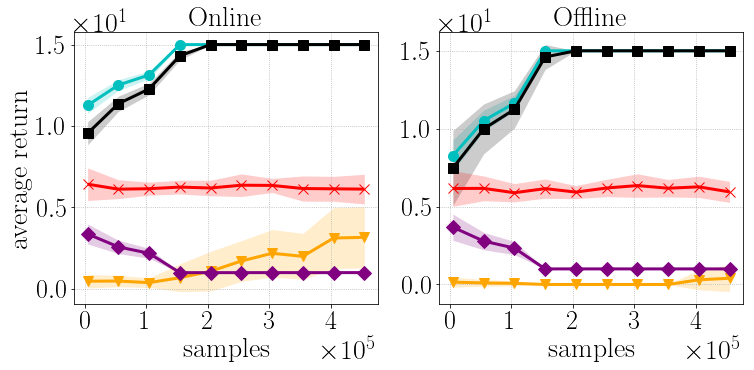

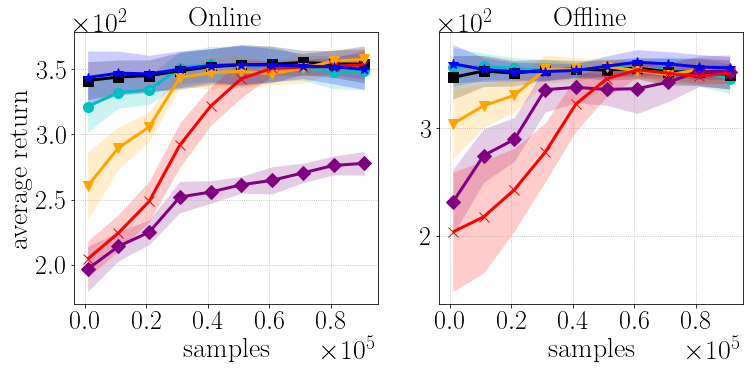

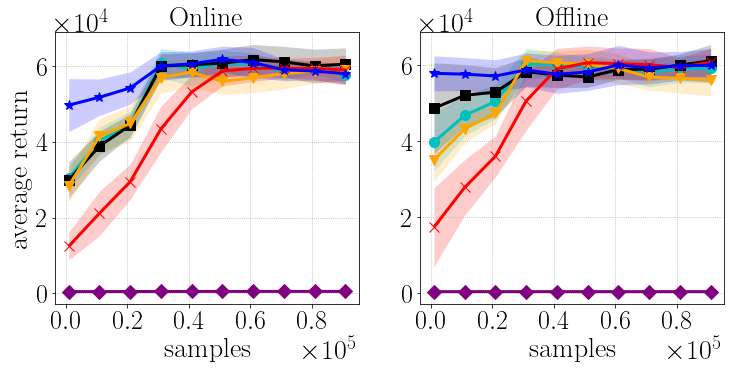

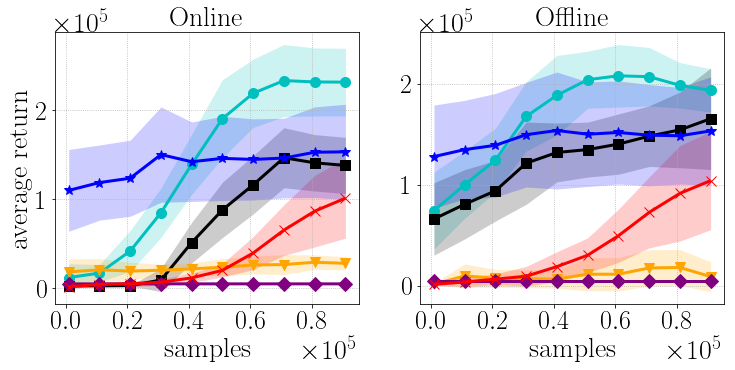

In [38]:
environments = ['Taxi','Chain','RiverSwim','SixArms']
algorithms = ['particle-ql','gaussian-ql','boot-ql','ql','delayed-ql','mbie']
policies = [['weighted','ucb'],['weighted-gaussian','ucb'],['boot','weighted'],['eps-greedy', 'boltzmann'],[''],['rmax']]
updates = [['weighted','mean'],['weighted','mean'],[''], [''],['']]
alg_to_label={
        'particle-ql':'P-WQL',
        'ql':'QL',
        'boot-ql':'BQL',
        'gaussian-ql':'G-WQL',
        'r-max':'Rmax',
        'mbie':'MBIE',
        'delayed-ql':'Delayed-QL'
}
policy_to_label={
        'weighted':'PS',
        'vpi':'V',
        'eps-greedy':'e-Gree',
        'boltzmann':'Boltz',
        'boot':'Boot',
        'weighted-gaussian':'PS',
        'rmax':'',
        'mbie':'',
        'ucb':'OFU',
        '':''
}
update_to_label={
        'weighted':'PO',
        'mean':'MO',
        'optimistic':'OO',
        '':''
}
alg_to_double_vec ={
        'particle-ql':['False'],
        'ql':['True'],
        'boot-ql':['True'],
        'gaussian-ql':['False'],
        'r-max':['False'],
        'mbie':['False'],
        'delayed-ql':['False']
}
env_to_algs= {
    'Taxi':(['gaussian-ql', 'particle-ql', 'boot-ql', 'ql','delayed-ql'], 
            [['weighted-gaussian',],['weighted',],['boot'], ['eps-greedy'],['']],
            [['mean'],['mean'],[''],[''],['']]),
    'Gridworld':(['gaussian-ql','particle-ql'],
            [['weighted-gaussian','ucb'],['weighted','ucb']],
            [ ['weighted','mean','optimistic'],['weighted','mean','optimistic']]),
    'Chain':(['gaussian-ql', 'particle-ql', 'boot-ql', 'ql','delayed-ql','mbie'], 
            [['ucb',],['ucb',],['boot'], ['eps-greedy'],[''],['mbie']],
            [['mean'],['mean'],[''],[''],[''],['']]),
    'RiverSwim':(['gaussian-ql', 'particle-ql', 'boot-ql', 'ql','delayed-ql','mbie'], 
            [['weighted-gaussian',],['weighted',],['boot'], ['eps-greedy'],[''],['mbie']],
            [['weighted'],['weighted'],[''],[''],[''],['']]),
    'SixArms':(['gaussian-ql', 'particle-ql', 'boot-ql', 'ql','delayed-ql','mbie'], 
            [['weighted-gaussian',],['weighted',],['boot'], ['eps-greedy'],[''],['mbie']],
            [['weighted'],['weighted'],[''],[''],[''],['']]),
    'KnightQuest':(['gaussian-ql', 'particle-ql', 'boot-ql', 'ql','delayed-ql'], 
            [['weighted-gaussian',],['weighted',],['boot'], ['eps-greedy'],['']],
            [['weighted'],['weighted'],[''],[''],['']]),
    'Loop':(['gaussian-ql', 'particle-ql', 'boot-ql', 'ql','delayed-ql'], 
            [['weighted-gaussian',],['weighted',],['boot'], ['eps-greedy'],['']],
            [['weighted'],['weighted'],[''],[''],['']]),
    
}
conf = 0.95
subsample = 10
legend_labels=[]
legend_colors=[]
legend_markers=[]
n_col = 2
limits=[(-50,0),(-10000,80000)]
for e,env in enumerate(environments):
    #if e%n_col == 0:
    fig, ax = plt.subplots(1, n_col, figsize=(12, 5))
    #fig.suptitle(env)
    algs, alg_policies, alg_updates = env_to_algs[env]
    i = 0    
    for j, alg in enumerate(algs):
        double_vec = alg_to_double_vec[alg]
        
        for pi in alg_policies[j]:
            for u in alg_updates[j]:
                for double in double_vec:
                    if pi in ['ucb']:
                        paths = glob.glob("./tabular_data/" + env + "/" + alg + "/results_" + pi + "_*_"+ u + "_*_"+"double=False_*.npy")
                    elif alg in ['delayed-ql']:
                        #results_delayed_m=1900_1547483900.8137288.npy
                        paths = glob.glob("./tabular_data/" + env + "/" + alg + "/results_delayed_*.npy")
                    elif alg not in ['gaussian-ql']:
                        paths = glob.glob("./tabular_data/" + env + "/" + alg + "/results_" + pi + "_*_"+ u + "_*_"+"double="+ double+"*.npy")
                    else:
                        paths = glob.glob("./tabular_data/" + env + "/" + alg + "/results_" + pi + "_*_"+ u + "_*_"+"double="+ double+"*_log_lr=False"+ "*.npy")                  
                    
                    #print(paths)
                    for p in paths:
                        results = np.load(p)
                        #print(results.shape)
                        n_runs = results.shape[0]
                        try:
                            timesteps = np.cumsum(results[:, 0, :, 0][0])
                            cum_reward_train = results[:, 0, :, 3]
                            cum_reward_test = results[:, 1, :, 3]
                        except:
                            b = np.zeros(shape=results.shape+(11,))
                            for  (x,h,k),value in np.ndenumerate(results):
                                for l in range(11):
                                    b[x,h,k,l]=results[x,h,k][l]
                            results=b
                            timesteps = np.cumsum(results[:, 0, :, 0][0])
                            cum_reward_train = results[:, 0, :, 3]
                            cum_reward_test = results[:, 1, :, 3]
                        

                        #print(cum_reward_test)
                        '''if alg in ['gaussian-ql','particle-ql']:
                            lab = alg_to_label[alg] + "-" +policy_to_label[pi]+ "-" + update_to_label[u]
                            
                        elif alg in ['boot-ql','ql','delayed-ql']:
                            lab = alg_to_label[alg]
                        else:
                            raise ValueError()''' #alg_to_label[alg] + "-" + policy_to_label[pi] + "-" + update_to_label[u]
                        #ax[e%n_col].set_title(env, fontdict={'fontsize':20})
                        ax[0].set_title('Online', fontdict={'fontsize':TITLE_SIZE})
                        indexes = [i*subsample for i in range(len(timesteps) // subsample)]
                        if e==1:
                            lab = alg_to_label[alg] #+ '-' +policy_to_label[pi] + '-' + update_to_label[u]
                            legend_labels.append(lab)
                            legend_colors.append(col[i])
                            legend_markers.append(markers[i])
                        if e%n_col ==0:
                            y_lab ='Average return'
                        else:
                            y_lab = None
                            
                        y_lab = 'Average return'
                        lab = ''
                        
                        ax[0] = plot_ci(timesteps[indexes],cum_reward_train[:,indexes], conf, 
                                    n_runs, xlabel='Samples', ylabel=y_lab, label=lab,
                                    ax=ax[0], linewidth=LINE_WIDTH, linestyle=ls[0], color=col[i], marker=markers[i], markersize=MARKER_SIZE)
                        #ax[0].set_ylim(limits[e])
                        ax[1].set_title('Offline', fontdict={'fontsize':TITLE_SIZE})
                        ax[1] = plot_ci(timesteps[indexes], cum_reward_test[:,indexes], conf, 
                                    n_runs, xlabel='Samples', 
                                    ax=ax[1], linewidth=LINE_WIDTH, linestyle=ls[0], color=col[i], marker=markers[i], markersize=MARKER_SIZE)
                        #ax[1].set_ylim(limits[e])'''
                        ax[0].grid(linestyle=":")
                        ax[0].locator_params(axis='x', nbins=6) 
                        ax[1].grid(linestyle=":")
                        ax[1].locator_params(axis='x', nbins=6) 
                        i += 1
    
        
    #lgd=fig.legend(loc='lower center', 
     #                     ncol=5, fancybox=True, shadow=True,bbox_to_anchor=(0.45, -0.015))
    '''if e%n_col == n_col-1:  
        e1 = environments[e-1]
        fig.savefig('images/appendix-'+e1+"-"+env+".pdf",format='pdf', bbox_inches='tight')'''
    fig.savefig('images2/'+env+".pdf",format='pdf', bbox_inches='tight')
    

fig = plt.figure(figsize=(7, 0.2))
patches = [
    mpatches.Patch(color=legend_colors[i], label=legend_labels[i], hatch=legend_markers[0])
    for i in range(len(legend_colors))]
patches = [ mlines.Line2D([], [], color=legend_colors[i], marker=legend_markers[i], markersize=MARKER_SIZE,
                          label=legend_labels[i], linewidth=LINE_WIDTH)  for i in range(len(legend_labels)) ]

lgd=fig.legend( patches, legend_labels, ncol=10, loc='center', frameon=False, fontsize=LEGEND_FONT_SIZE)
fig.savefig('images2/legend.pdf',format='pdf',bbox_extra_artists=(lgd,), bbox_inches='tight',)




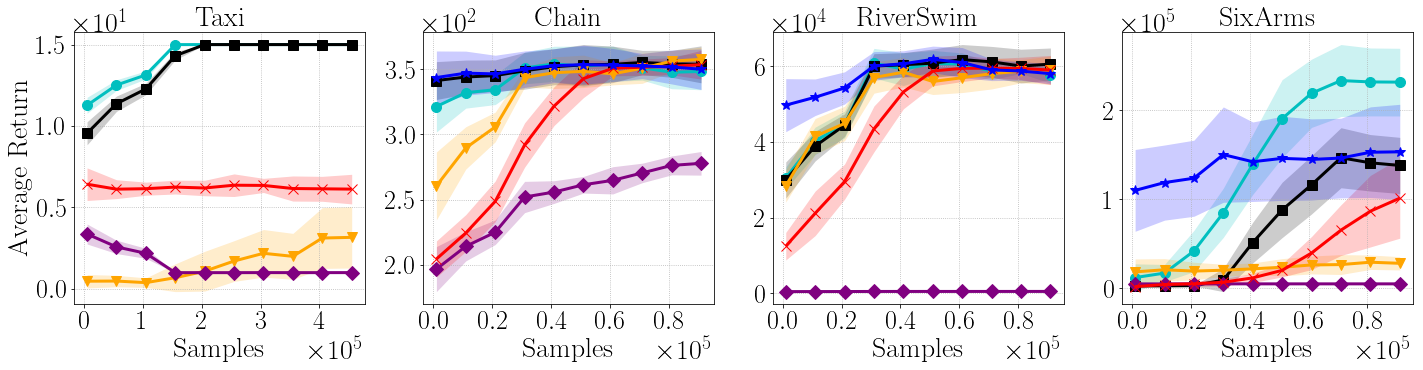

In [36]:
environments = ['Taxi','Chain','RiverSwim','SixArms']
algorithms = ['particle-ql','gaussian-ql','boot-ql','ql','delayed-ql','mbie']
policies = [['weighted','ucb'],['weighted-gaussian','ucb'],['boot','weighted'],['eps-greedy', 'boltzmann'],[''],['rmax']]
updates = [['weighted','mean'],['weighted','mean'],[''], [''],['']]
alg_to_label={
        'particle-ql':'P-WQL',
        'ql':'QL',
        'boot-ql':'BQL',
        'gaussian-ql':'G-WQL',
        'r-max':'Rmax',
        'mbie':'MBIE',
        'delayed-ql':'Delayed-QL'
}
policy_to_label={
        'weighted':'PS',
        'vpi':'V',
        'eps-greedy':'e-Gree',
        'boltzmann':'Boltz',
        'boot':'Boot',
        'weighted-gaussian':'PS',
        'rmax':'',
        'mbie':'',
        'ucb':'OFU',
        '':''
}
update_to_label={
        'weighted':'PO',
        'mean':'MO',
        'optimistic':'OO',
        '':''
}
alg_to_double_vec ={
        'particle-ql':['False'],
        'ql':['True'],
        'boot-ql':['True'],
        'gaussian-ql':['False'],
        'r-max':['False'],
        'mbie':['False'],
        'delayed-ql':['False']
}
env_to_algs= {
    'Taxi':(['gaussian-ql', 'particle-ql', 'boot-ql', 'ql','delayed-ql'], 
            [['weighted-gaussian',],['weighted',],['boot'], ['eps-greedy'],['']],
            [['mean'],['mean'],[''],[''],['']]),
    'Gridworld':(['gaussian-ql','particle-ql'],
            [['weighted-gaussian','ucb'],['weighted','ucb']],
            [ ['weighted','mean','optimistic'],['weighted','mean','optimistic']]),
    'Chain':(['gaussian-ql', 'particle-ql', 'boot-ql', 'ql','delayed-ql','mbie'], 
            [['ucb',],['ucb',],['boot'], ['eps-greedy'],[''],['mbie']],
            [['mean'],['mean'],[''],[''],[''],['']]),
    'RiverSwim':(['gaussian-ql', 'particle-ql', 'boot-ql', 'ql','delayed-ql','mbie'], 
            [['weighted-gaussian',],['weighted',],['boot'], ['eps-greedy'],[''],['mbie']],
            [['weighted'],['weighted'],[''],[''],[''],['']]),
    'SixArms':(['gaussian-ql', 'particle-ql', 'boot-ql', 'ql','delayed-ql','mbie'], 
            [['weighted-gaussian',],['weighted',],['boot'], ['eps-greedy'],[''],['mbie']],
            [['weighted'],['weighted'],[''],[''],[''],['']]),
    'KnightQuest':(['gaussian-ql', 'particle-ql', 'boot-ql', 'ql','delayed-ql'], 
            [['weighted-gaussian',],['weighted',],['boot'], ['eps-greedy'],['']],
            [['weighted'],['weighted'],[''],[''],['']]),
    'Loop':(['gaussian-ql', 'particle-ql', 'boot-ql', 'ql','delayed-ql'], 
            [['weighted-gaussian',],['weighted',],['boot'], ['eps-greedy'],['']],
            [['weighted'],['weighted'],[''],[''],['']]),
    
}
conf = 0.95
subsample = 10
legend_labels=[]
legend_colors=[]
legend_markers=[]
n_col = 4
limits=[(-50,0),(-10000,80000)]
fig, ax = plt.subplots(1, 4, figsize=(24, 5))
print(ax)
i = 0
for e,env in enumerate(environments):
    #if e%n_col == 0:
    
    #fig.suptitle(env)
    algs, alg_policies, alg_updates = env_to_algs[env]
    i = 0    
    for j, alg in enumerate(algs):
        double_vec = alg_to_double_vec[alg]
        
        for pi in alg_policies[j]:
            for u in alg_updates[j]:
                for double in double_vec:
                    if pi in ['ucb']:
                        paths = glob.glob("./tabular_data/" + env + "/" + alg + "/results_" + pi + "_*_"+ u + "_*_"+"double=False_*.npy")
                    elif alg in ['delayed-ql']:
                        #results_delayed_m=1900_1547483900.8137288.npy
                        paths = glob.glob("./tabular_data/" + env + "/" + alg + "/results_delayed_*.npy")
                    elif alg not in ['gaussian-ql']:
                        paths = glob.glob("./tabular_data/" + env + "/" + alg + "/results_" + pi + "_*_"+ u + "_*_"+"double="+ double+"*.npy")
                    else:
                        paths = glob.glob("./tabular_data/" + env + "/" + alg + "/results_" + pi + "_*_"+ u + "_*_"+"double="+ double+"*_log_lr=False"+ "*.npy")                  
                    
                    #print(paths)
                    for p in paths:
                        results = np.load(p)
                        #print(results.shape)
                        n_runs = results.shape[0]
                        try:
                            timesteps = np.cumsum(results[:, 0, :, 0][0])
                            cum_reward_train = results[:, 0, :, 3]
                            cum_reward_test = results[:, 1, :, 3]
                        except:
                            b = np.zeros(shape=results.shape+(11,))
                            for  (x,h,k),value in np.ndenumerate(results):
                                for l in range(11):
                                    b[x,h,k,l]=results[x,h,k][l]
                            results=b
                            timesteps = np.cumsum(results[:, 0, :, 0][0])
                            cum_reward_train = results[:, 0, :, 3]
                            cum_reward_test = results[:, 1, :, 3]
                        

                        #print(cum_reward_test)
                        '''if alg in ['gaussian-ql','particle-ql']:
                            lab = alg_to_label[alg] + "-" +policy_to_label[pi]+ "-" + update_to_label[u]
                            
                        elif alg in ['boot-ql','ql','delayed-ql']:
                            lab = alg_to_label[alg]
                        else:
                            raise ValueError()''' #alg_to_label[alg] + "-" + policy_to_label[pi] + "-" + update_to_label[u]
                        #ax[e%n_col].set_title(env, fontdict={'fontsize':20})
                        ax[e].set_title(env, fontdict={'fontsize':TITLE_SIZE})
                        indexes = [i*subsample for i in range(len(timesteps) // subsample)]
                        if e==1:
                            lab = alg_to_label[alg] #+ '-' +policy_to_label[pi] + '-' + update_to_label[u]
                            legend_labels.append(lab)
                            legend_colors.append(col[i])
                            legend_markers.append(markers[i])
                        if e%n_col ==0:
                            y_lab ='average return'
                        else:
                            y_lab = None
                            
                        if e == 0:
                            y_lab = 'Average Return'
                        else:
                            y_lab = ''
                            
                 
                        ax[e] = plot_ci(timesteps[indexes],cum_reward_train[:,indexes], conf, 
                                    n_runs, xlabel='Samples', ylabel=y_lab, label='',
                                    ax=ax[e], linewidth=LINE_WIDTH, linestyle=ls[0], color=col[i], marker=markers[i], markersize=MARKER_SIZE)
                        #ax[0].set_ylim(limits[e])
         
                        ax[e].grid(linestyle=":")
                        ax[e].locator_params(axis='x', nbins=6) 
                        i += 1
                        
    
        
    #lgd=fig.legend(loc='lower center', 
     #                     ncol=5, fancybox=True, shadow=True,bbox_to_anchor=(0.45, -0.015))
    '''if e%n_col == n_col-1:  
        e1 = environments[e-1]
        fig.savefig('images/appendix-'+e1+"-"+env+".pdf",format='pdf', bbox_inches='tight')'''
       
fig.savefig('images2/all.pdf',format='pdf', bbox_inches='tight')

fig = plt.figure(figsize=(7, 0.2))
patches = [
    mpatches.Patch(color=legend_colors[i], label=legend_labels[i], hatch=legend_markers[0])
    for i in range(len(legend_colors))]
patches = [ mlines.Line2D([], [], color=legend_colors[i], marker=legend_markers[i], markersize=MARKER_SIZE,
                          label=legend_labels[i], linewidth=LINE_WIDTH)  for i in range(len(legend_labels)) ]

lgd=fig.legend( patches, legend_labels, ncol=10, loc='center', frameon=False, fontsize=LEGEND_FONT_SIZE)
fig.savefig('images2/legend.pdf',format='pdf',bbox_extra_artists=(lgd,), bbox_inches='tight',)



In [37]:
fig = plt.figure(figsize=(7, 0.2))
patches = [ mlines.Line2D([], [], color=legend_colors[i], marker=legend_markers[i], markersize=MARKER_SIZE,
                          label=legend_labels[i], linewidth=LINE_WIDTH)  for i in range(len(legend_labels)) ]

lgd=fig.legend( patches, legend_labels, ncol=10, loc='center', frameon=False, fontsize=LEGEND_FONT_SIZE)
fig.savefig('images2/legend.pdf',format='pdf',bbox_extra_artists=(lgd,), bbox_inches='tight',)

plt.show()

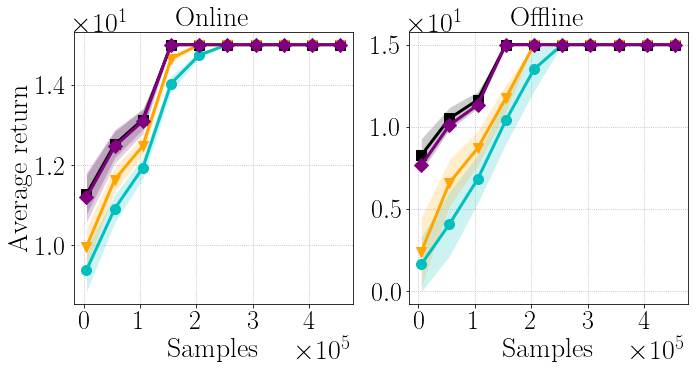

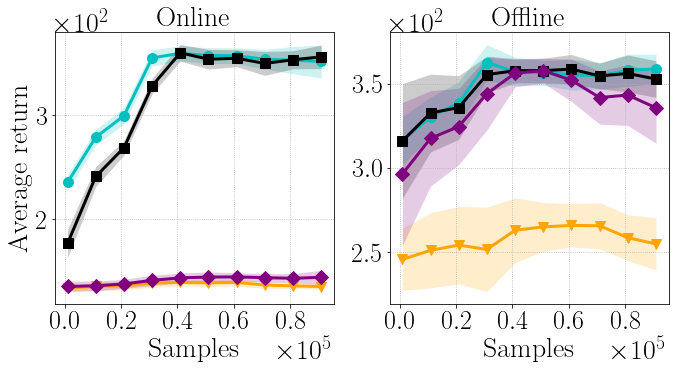

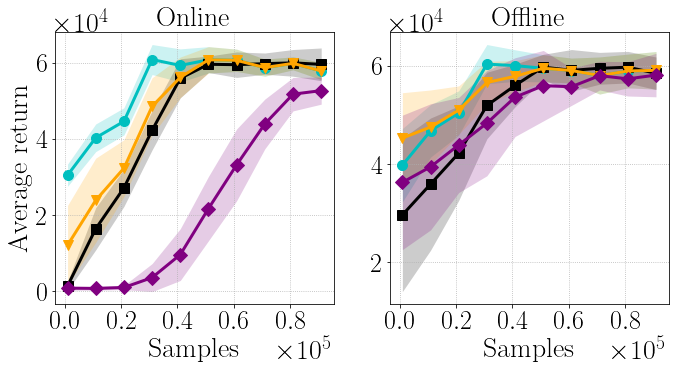

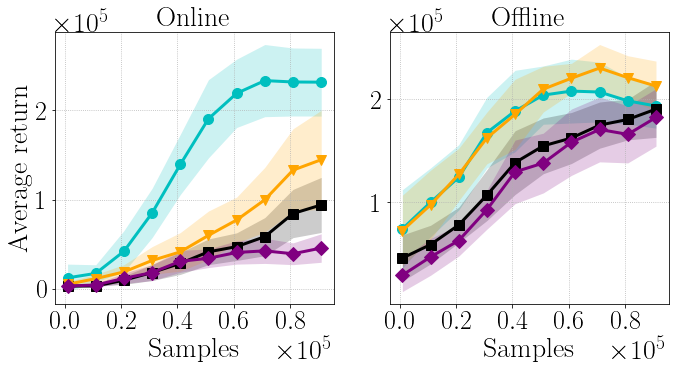

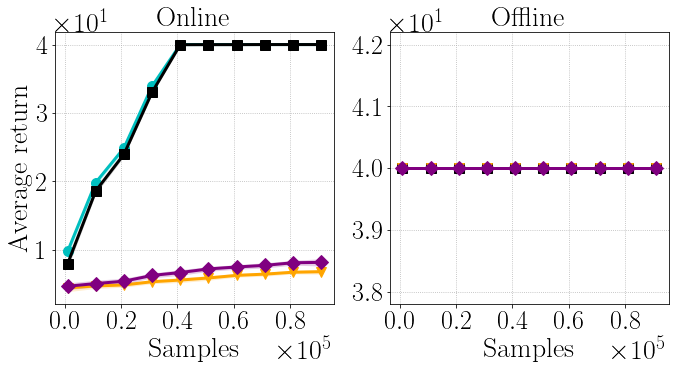

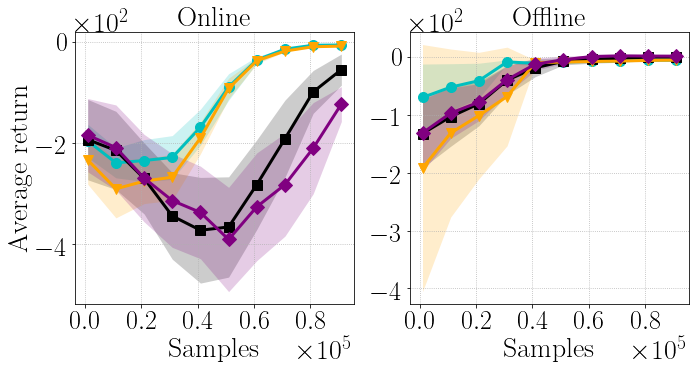

In [41]:
#Gaussian QL with different learning rates
environments = ['Taxi','Chain','RiverSwim','SixArms', 'Loop', 'KnightQuest']
algorithms = ['gaussian-ql']
policies = [['weighted-gaussian'],['boot','weighted'],['eps-greedy', 'boltzmann']]
updates = [['weighted','mean'],['weighted','mean'],[''], ['']]
log_vec = ['False','True']
alg_to_label={
        'particle-ql':'P-WQL',
        'ql':'QL',
        'boot-ql':'BQL',
        'gaussian-ql':'G-WQL'
}
policy_to_label={
        'weighted':'PS',
        'vpi':'V',
        'eps-greedy':'e-Gree',
        'boltzmann':'Boltz',
        'boot':'Boot',
        'weighted-gaussian':'PS'
}
update_to_label={
        'weighted':'PO',
        'mean':'MO',
        'optimistic':'OO',
        '':''
}
alg_to_double_vec ={
        'particle-ql':['False'],
        'ql':['True'],
        'boot-ql':['True'],
        'gaussian-ql':['False']
}
conf = 0.95
limits=[(-1,17.5),(-10000,80000)]
n_col = 2
subsample = 10
legend_labels = []
legend_colors = []
legend_markers = []
for e,env in enumerate(environments):
    #if e % n_col ==0:
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))
    #fig.suptitle(env)
    i = 0    
    for j, alg in enumerate(algorithms):
        double_vec = alg_to_double_vec[alg]
        for nm, log in enumerate(log_vec):
            for pi in policies[j]:
                for u in updates[j]:
                    for double in double_vec:
                        paths = glob.glob("./tabular_data/" + env + "/" + alg + "/results_" + pi + "_*_"+ u + "_*_"+"double="+ double+"*_log_lr="+log+ "*.npy")                  
                    #print(paths)
                        for p in paths:
                            results = np.load(p)
                            #print(results.shape)
                            n_runs = results.shape[0]
                            try:
                                timesteps = np.cumsum(results[:, 0, :, 0][0])
                                cum_reward_train = results[:, 0, :, 3]
                                cum_reward_test = results[:, 1, :, 3]
                            except:
                                b = np.zeros(shape=results.shape+(11,))
                                for  (x,h,k),value in np.ndenumerate(results):
                                    for l in range(11):
                                        b[x,h,k,l]=results[x,h,k][l]
                                results=b
                                timesteps = np.cumsum(results[:, 0, :, 0][0])
                                cum_reward_train = results[:, 0, :, 3]
                                cum_reward_test = results[:, 1, :, 3]
                        

                            #print(cum_reward_test)
                        if e == 0:
                            lab = alg_to_label[alg] + "-" + update_to_label[u]
                            if log =='True':
                                lab += '-conv'
                            legend_labels.append(lab)
                            legend_colors.append(col[i])
                            legend_markers.append(markers[i])
                        indexes = [i*subsample for i in range(len(timesteps) // subsample)]
                        ax[0].set_title('Online', fontdict={'fontsize':TITLE_SIZE})
                        ax[0] = plot_ci(timesteps[indexes],cum_reward_train[:,indexes], conf, 
                                    n_runs, xlabel='Samples', ylabel='Average return', label=lab,
                                    ax=ax[0], linewidth=LINE_WIDTH, linestyle=ls[0], color=col[i], marker = markers[i],  markersize=MARKER_SIZE)
                        #ax[0].set_ylim(limits[e])
                        ax[1].set_title('Offline', fontdict={'fontsize':TITLE_SIZE})
                        ax[1] = plot_ci(timesteps[indexes], cum_reward_test[:,indexes], conf, 
                                    n_runs, xlabel='Samples', ylabel=None, 
                                    ax=ax[1], linewidth=LINE_WIDTH, linestyle=ls[0], color=col[i], marker=markers[i],  markersize=MARKER_SIZE)
                        #ax[1].set_ylim(limits[e])
                        ax[0].grid(linestyle=":")
                        ax[0].locator_params(axis='x', nbins=6) 
                        ax[1].grid(linestyle=":")
                        ax[1].locator_params(axis='x', nbins=6) 
                        
                        i += 1
    #lgd=fig.legend(loc='lower center', 
                          #ncol=2, fancybox=True, shadow=True,bbox_to_anchor=(0.45, -0.01))
    #if e%n_col == n_col-1:
        #e1 = environments[e-1]
        #fig.savefig('images/lr_'+e1+"-"+env+".pdf",format='pdf', bbox_inches='tight')
    fig.savefig('images2/lr-'+env+".pdf",format='pdf', bbox_inches='tight')
                       
fig = plt.figure(figsize=(7, 0.2))
'''patches = [
    mpatches.Patch(color=legend_colors[i], label=legend_labels[i])
    for i in range(len(legend_colors))]'''
patches = [ mlines.Line2D([], [], color=legend_colors[i], marker=legend_markers[i],  markersize=MARKER_SIZE, 
                          label=legend_labels[i], linewidth=LINE_WIDTH)  for i in range(len(legend_labels)) ]

lgd=fig.legend( patches, legend_labels, ncol=10, 
           loc='center')
fig.savefig('images2/lr-legend.pdf',format='pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')              


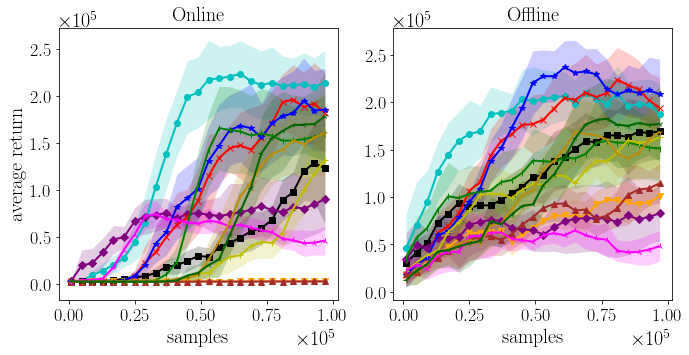

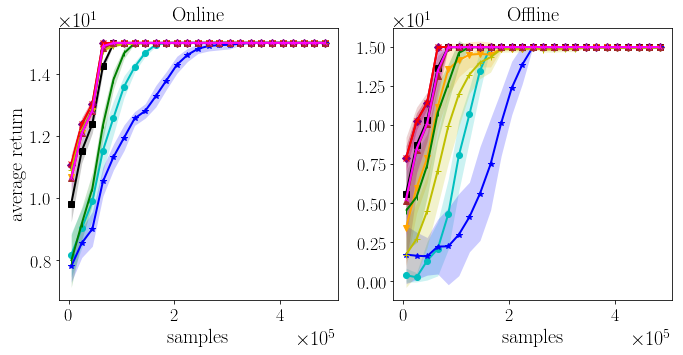

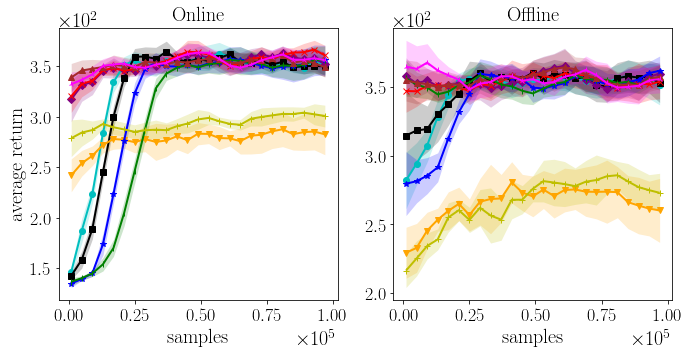

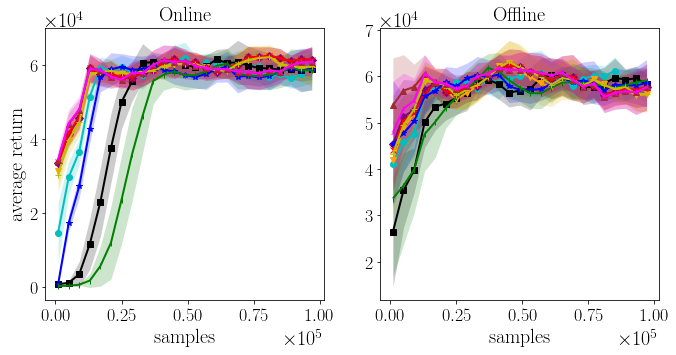

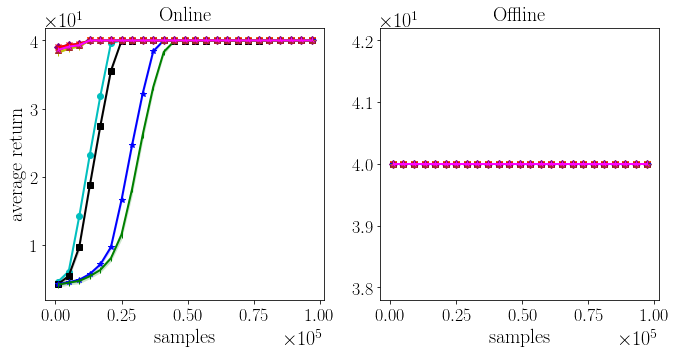

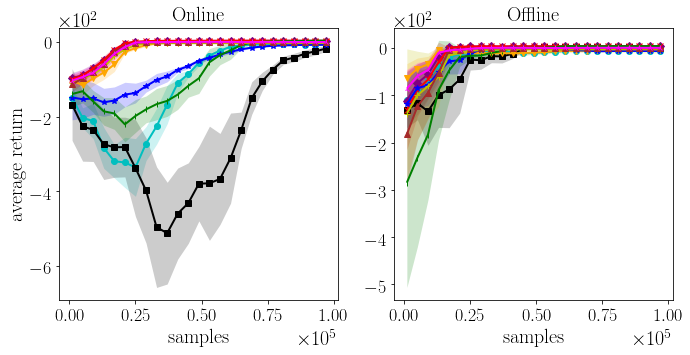

<Figure size 792x360 with 0 Axes>

In [59]:
#BW QL all versions
environments = ['SixArms','Taxi','Chain','RiverSwim', 'Loop', 'KnightQuest']#,'SixArms',
algorithms = ['gaussian-ql','particle-ql']
policies = [['weighted-gaussian', 'ucb'], ['weighted','ucb'],['boot','weighted'],['eps-greedy', 'boltzmann']]
updates = [['weighted','mean','optimistic'],['weighted','mean','optimistic'],[''], ['']]
log_vec = ['False','True']
alg_to_label={
        'particle-ql':'P-WQL',
        'ql':'QL',
        'boot-ql':'BQL',
        'gaussian-ql':'G-WQL'
}
policy_to_label={
        'weighted':'PS',
        'vpi':'V',
        'eps-greedy':'e-Gree',
        'boltzmann':'Boltz',
        'boot':'Boot',
        'weighted-gaussian':'PS',
        'ucb':'OFU'
}
update_to_label={
        'weighted':'PO',
        'mean':'MO',
        'optimistic':'OO',
        '':''
}
alg_to_double_vec ={
        'particle-ql':['False'],
        'ql':['True'],
        'boot-ql':['True'],
        'gaussian-ql':['False']
}
conf = 0.95
subsample = 4
limits=[(-1,17.5),(-10000,80000)]
n_col = 2
legend_labels = []
legend_colors = []
legend_markers = []
for e,env in enumerate(environments):
    #if e % n_col ==0:
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))
    #fig.suptitle(env)
    i = 0    
    for j, alg in enumerate(algorithms):
        double_vec = alg_to_double_vec[alg]
        for pi in policies[j]:
                for u in updates[j]:
                    for double in double_vec:
                        if pi in ['ucb']:
                            paths = glob.glob("./tabular_data/" + env + "/" + alg + "/results_" + pi + "_*_"+ u + "_*_"+"double=False_*.npy")
                        elif alg not in ['gaussian-ql']:
                            paths = glob.glob("./tabular_data/" + env + "/" + alg + "/results_" + pi + "_*_"+ u + "_*_"+"double=False_*.npy")
                        else:
                            paths = glob.glob("./tabular_data/" + env + "/" + alg + "/results_" + pi + "_*_"+ u + "_*_"+"double=False*_log_lr=False"+ "*.npy")                  
                    #print(paths)
                        for p in paths:
                            results = np.load(p)
                            #print(results.shape)
                            n_runs = results.shape[0]
                            try:
                                timesteps = np.cumsum(results[:, 0, :, 0][0])
                                cum_reward_train = results[:, 0, :, 3]
                                cum_reward_test = results[:, 1, :, 3]
                            except:
                                b = np.zeros(shape=results.shape+(11,))
                                for  (x,h,k),value in np.ndenumerate(results):
                                    for l in range(11):
                                        b[x,h,k,l]=results[x,h,k][l]
                                results=b
                                timesteps = np.cumsum(results[:, 0, :, 0][0])
                                cum_reward_train = results[:, 0, :, 3]
                                cum_reward_test = results[:, 1, :, 3]
                        

                            #print(cum_reward_test)
                        if len(paths) == 0:
                            continue
                        lab = alg_to_label[alg] + "-" +policy_to_label[pi] + "-" + update_to_label[u]
                        if e == 0:
                            legend_labels.append(lab)
                            legend_colors.append(col[i])
                            legend_markers.append(markers[i])
                        indexes = [i*subsample for i in range(len(timesteps) // subsample)]
                        markers_on=[i* 2]
                        ax[0].set_title('Online', fontdict={'fontsize':20})
                        ax[0] = plot_ci(timesteps[indexes],cum_reward_train[:,indexes], conf, 
                                    n_runs, xlabel='samples', ylabel='average return', label=lab, marker=markers[i],
                                    ax=ax[0], linewidth=2.0, linestyle=ls[0], color=col[i],)
                        #ax[0].set_ylim(limits[e])
                        ax[1].set_title('Offline', fontdict={'fontsize':20})
                        ax[1] = plot_ci(timesteps[indexes], cum_reward_test[:,indexes], conf, 
                                    n_runs, xlabel='samples', ylabel=None, marker=markers[i],
                                    ax=ax[1], linewidth=2.0, linestyle=ls[0], color=col[i],)
                        #ax[1].set_ylim(limits[e])
                        i += 1
    #lgd=fig.legend(loc='lower right', 
     #                   ncol=1, fancybox=True, shadow=True)#
    #if e%n_col == n_col-1:
        #e1 = environments[e-1]
        #fig.savefig('images/lr_'+e1+"-"+env+".pdf",format='pdf', bbox_inches='tight')
    if env != 'SixArms':
        fig.savefig('images/BW-'+env+".pdf",format='pdf', bbox_inches='tight')
    else:
        fig.savefig('images/BW-'+env+"_2.pdf",format='pdf', bbox_inches='tight')#,bbox_extra_artists=(lgd,)
fig = plt.figure(figsize=(11, 5))
patches = [ mlines.Line2D([], [], color=legend_colors[i], marker=legend_markers[i],
                          label=legend_labels[i])  for i in range(len(legend_labels)) ]

lgd=fig.legend( patches, legend_labels, ncol=6, 
           loc='center')
fig.savefig('images/BW-legend.pdf',format='pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')              





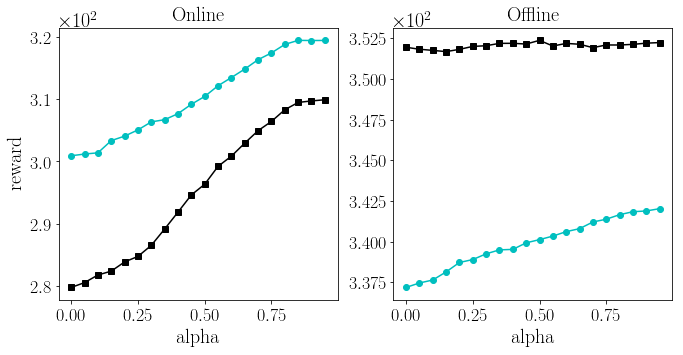

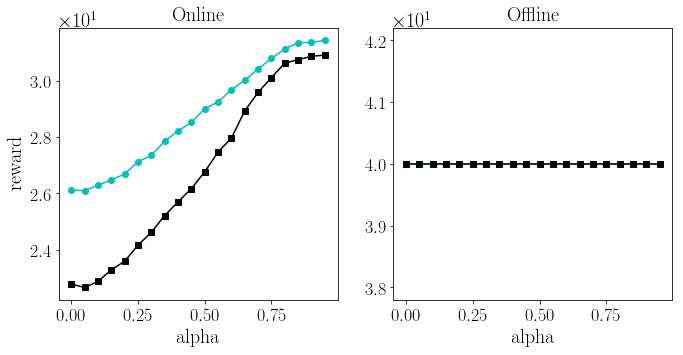

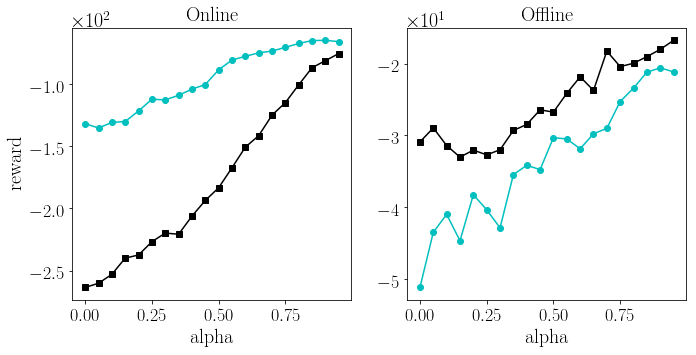

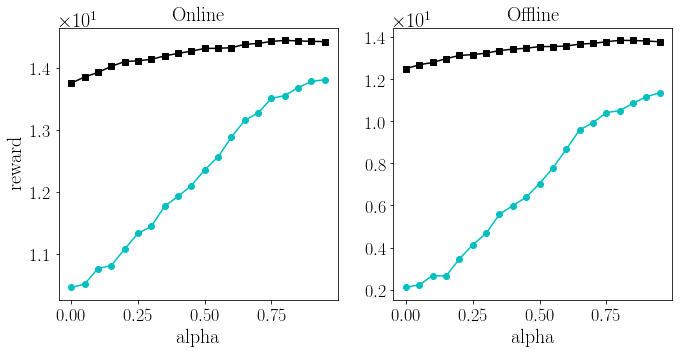

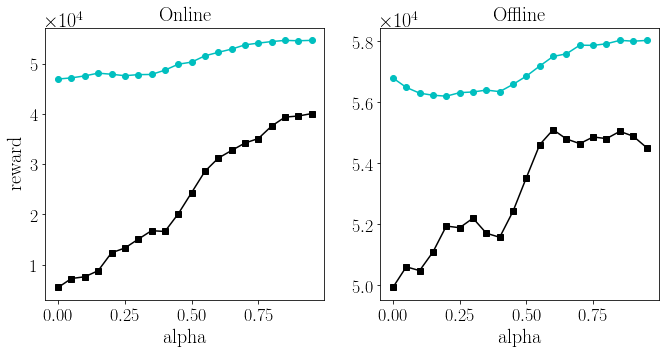

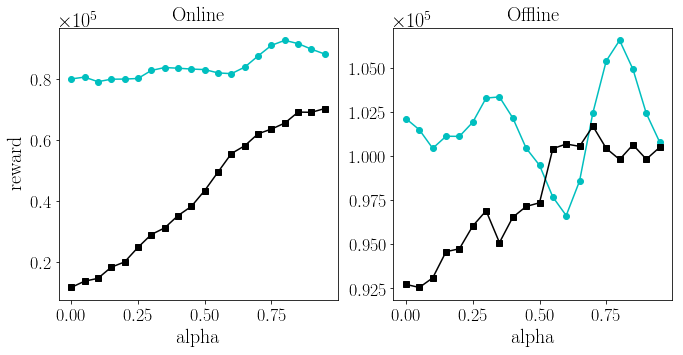

<Figure size 792x360 with 0 Axes>

In [61]:
#different inits for particle ql
environments = ['Chain','Loop','KnightQuest','Taxi','RiverSwim','SixArms']
algorithms = ['particle-ql']
policies = [['weighted'],['boot','weighted'],['eps-greedy', 'boltzmann']]
updates = [['weighted','mean','optimistic'],[''], ['']]
alg_to_label={
        'particle-ql':'P-WQL',
        'ql':'QL',
        'boot-ql':'BQL'
}
policy_to_label={
        'weighted':'PS',
        'vpi':'V',
        'eps-greedy':'e-Gree',
        'boltzmann':'Boltz',
        'boot':'Boot',
        'ucb':'OFU'
}
update_to_label={
        'weighted':'PO',
        'mean':'MO',
        'optimistic':'OO',
        '':''
}
conf = 0.95
max_alpha=1
delta_alpha=0.05
legend_labels = []
legend_colors = []
legend_markers = []
limits=[(-10000,80000),(-1,17.5),(0,420),(0,50),(0,110000),(-200,10)]
for e,env in enumerate(environments):
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))
    #fig.suptitle(env)
    i = 0    
    for j, alg in enumerate(algorithms):
        for pi in policies[j]:
            for u in updates[j]:
                
                xs=[]
                ys=[]
                zs_train=[]
                zs_test=[]
                data_std_train=[]
                data_std_test=[]
                #print("%s_%s" %(pi,u))
                #results_noise_weighted_20_mean_0.2_1539254826.2738013_coef=0.15000000000000002.npy
                paths = glob.glob("./noise_data/"+env + "/particle-ql/results_noise_" + pi + "_*_"+ u + "_*_*_coef=*.npy")
                #print(paths)
                for p in paths:
                        alpha=float(str.split(p,'=')[1][:-4])
                        xs.append(alpha)
                        results = np.load(p)
                        #print(results.shape)
                        n_runs = results.shape[0]
                        try:
                            timesteps = np.cumsum(results[:, 0, :, 0][0])
                            cum_reward_train = results[:, 0, :, 3]
                            cum_reward_test = results[:, 1, :, 3]
                        except:
                            b = np.zeros(shape=results.shape+(11,))
                            for  (x,h,k),value in np.ndenumerate(results):
                                for l in range(11):
                                    b[x,h,k,l]=results[x,h,k][l]
                            results=b
                            timesteps = np.cumsum(results[:, 0, :, 0][0])
                            cum_reward_train = results[:, 0, :, 3]
                            cum_reward_test = results[:, 1, :, 3]
                        data_std_train.append(np.std(cum_reward_train, axis=0) + 1e-24)
                        zs_train.append(np.mean(cum_reward_train,axis=0))
                        data_std_test.append(np.std(cum_reward_test, axis=0) + 1e-24)
                        zs_test.append(np.mean(cum_reward_test,axis=0))
                if len(paths) == 0:
                    continue
                ys=timesteps
                
                zs_train=np.array(zs_train)
                data_std_train=np.array(data_std_train)
                zs_test=np.array(zs_test)
                data_std_test=np.array(data_std_test)
                xs=np.array(xs)
                color = col[i]
                #print(np.array(xs).shape)
                #print(np.array(ys).shape)
                #print(zs.shape)
                zs_train=zs_train.mean(axis=1)
                data_std_train=data_std_train.mean(axis=1)
                zs_test=zs_test.mean(axis=1)
                data_std_test=data_std_test.mean(axis=1)
                
                inds=xs.argsort()
                zs_test=zs_test[inds]
                zs_train=zs_train[inds]
                xs=np.sort(xs)
                label=alg_to_label[alg] + "-" + policy_to_label[pi] + "-" + update_to_label[u]
                if e == 0:
                    legend_labels.append(label)
                    legend_colors.append(color)
                    legend_markers.append(markers[i])
                lim=limits[e]
                N = 4
                zs_train = running_mean(zs_train,N)
                ax[0].set_title('Online', fontdict={'fontsize':20})
                ax[0].plot(xs,zs_train,label=label,color=color, marker=markers[i])
                #ax[0].set_ylim(bottom=lim[0],top=lim[1])
                zs_test = running_mean(zs_test,N)
                ax[1].set_title("Offline", fontdict={'fontsize':20})
                ax[1].plot(xs,zs_test,color=color, marker=markers[i])
                #ax[0].set_ylim(bottom=lim[0],top=lim[1])
                
                ax[0].set_xlabel('alpha', fontsize=AXIS_FONT_SIZE)
                ax[0].set_ylabel('reward', fontsize=AXIS_FONT_SIZE)
                ax[1].set_xlabel('alpha', fontsize=AXIS_FONT_SIZE)
                ax[0].ticklabel_format(style='sci',scilimits=(0,0))
                ax[0].yaxis.offsetText.set_fontsize(TICKS_FONT_SIZE+2)
                ax[0].tick_params(labelsize=TICKS_FONT_SIZE)
                ax[1].ticklabel_format(style='sci',scilimits=(0,0))
                ax[1].yaxis.offsetText.set_fontsize(TICKS_FONT_SIZE+2)
                ax[1].tick_params(labelsize=TICKS_FONT_SIZE)
                #ax[1].set_ylabel('reward', fontsize=AXIS_FONT_SIZE)
                #FILL REGION
                '''print(n_runs)
                interval_train = sts.t.interval(conf, n_runs-1,loc=zs_train,scale=data_std_train/np.sqrt(n_runs))
                interval_test = sts.t.interval(conf, n_runs-1,loc=zs_test,scale=data_std_test/np.sqrt(n_runs))
                #
                #ax.plot(xs, zs, label=label,  linewidth=2.0, linestyle=ls[i])
                ax[0].fill_between(xs, interval_train[0], interval_train[1], alpha=0.2, color=color, linewidth=0.)
                ax[1].fill_between(xs, interval_test[0], interval_test[1], alpha=0.2, color=color, linewidth=0.)'''
                #3D PLOT CODE
                #Xm,Ym=np.meshgrid(np.array(ys),np.array(xs))
                #ax=Axes3D(plt.gcf())
                #ax.plot_surface(Xm,Ym,zs,cmap=cm.coolwarm,linewidth=0, antialiased=False)
                #ax.view_init(azim=0, elev=10
                
                i+=1
    #lgd=fig.legend(loc='lower center', 
                          #ncol=2, fancybox=True, shadow=True,bbox_to_anchor=(0.45, -0.01))
    fig.savefig('images/init_'+env+".pdf",format='pdf', bbox_inches='tight')#,bbox_extra_artists=(lgd,)
                      
fig = plt.figure(figsize=(11, 5))
patches = [ mlines.Line2D([], [], color=legend_colors[i], marker=legend_markers[i],
                          label=legend_labels[i])  for i in range(len(legend_labels)) ]

lgd=fig.legend( patches, legend_labels, ncol=10, 
           loc='center')
fig.savefig('images/init_legend.pdf',format='pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')                           





Env:Chain; Max:322.64720000000005; m:17.0
Env:KnightQuest; Max:-66.94695546400474; m:5.0
Env:Taxi; Max:6.444913924869049; m:1900.0
Env:RiverSwim; Max:49735.769499999995; m:17.0
Env:SixArms; Max:44914.546500000004; m:25.0


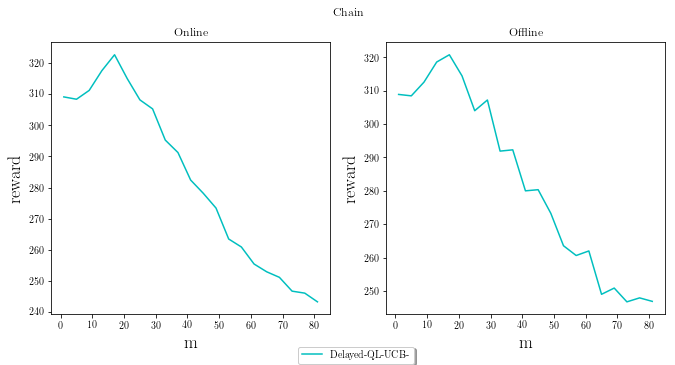

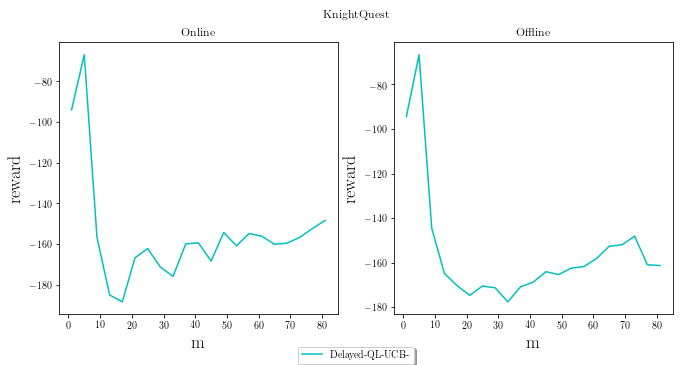

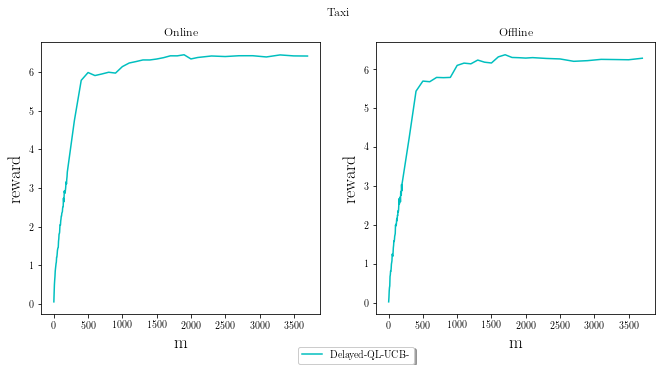

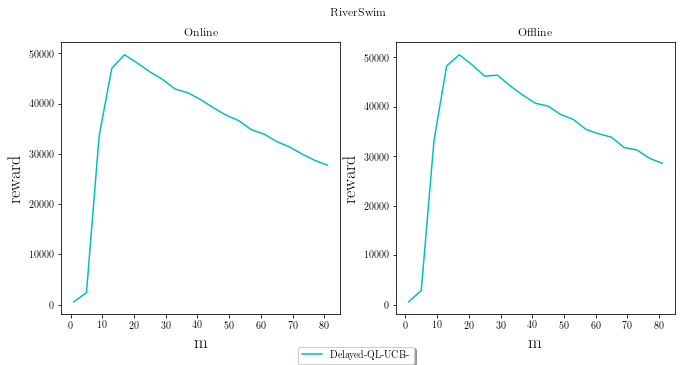

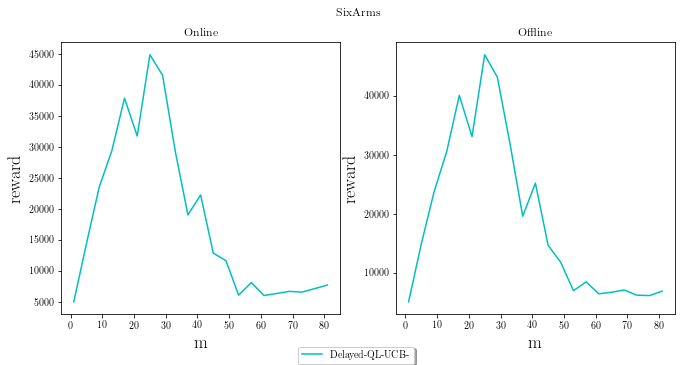

In [63]:
#different inits for particle ql
environments = ['Chain','KnightQuest','Taxi','RiverSwim','SixArms']
algorithms = ['delayed-ql']
policies = [['ucb'],['boot','weighted'],['eps-greedy', 'boltzmann']]
updates = [[''],['weighted','mean'], ['']]
alg_to_label={
        'particle-ql':'P-WQL',
        'ql':'QL',
        'boot-ql':'BQL',
        'delayed-ql':'Delayed-QL'
}
policy_to_label={
        'weighted':'W',
        'vpi':'V',
        'eps-greedy':'e-Gree',
        'boltzmann':'Boltz',
        'boot':'Boot',
        'ucb':'UCB'
}
update_to_label={
        'weighted':'W',
        'mean':'M',
        '':''
}
conf = 0.95
max_m=81
delta_m=4
limits=[(-10000,80000),(-1,17.5),(0,420),(0,50),(0,110000),(-200,10)]
for e,env in enumerate(environments):
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))
    fig.suptitle(env)
    i = 0    
    for j, alg in enumerate(algorithms):
        for pi in policies[j]:
            for u in updates[j]:
                
                xs=[]
                ys=[]
                zs_train=[]
                zs_test=[]
                data_std_train=[]
                data_std_test=[]
                #print("%s_%s" %(pi,u))
                #results_noise_weighted_20_mean_0.2_1539254826.2738013_coef=0.15000000000000002.npy
                #results_delayed_m=1_1547466733.0157294.npy
                paths = glob.glob("./delayed_q/" + env + "/delayed-ql/results_delayed_m=*.npy")
                #print(paths)
                for p in paths:
                        m=float(str.split(str.split(p,'=')[1],'_')[0])
                        xs.append(m)
                        results = np.load(p)
                        #print(results.shape)
                        n_runs = results.shape[0]
                        try:
                            timesteps = np.cumsum(results[:, 0, :, 0][0])
                            cum_reward_train = results[:, 0, :, 3]
                            cum_reward_test = results[:, 1, :, 3]
                        except:
                            b = np.zeros(shape=results.shape+(11,))
                            for  (x,h,k),value in np.ndenumerate(results):
                                for l in range(11):
                                    b[x,h,k,l]=results[x,h,k][l]
                            results=b
                            timesteps = np.cumsum(results[:, 0, :, 0][0])
                            cum_reward_train = results[:, 0, :, 3]
                            cum_reward_test = results[:, 1, :, 3]
                        data_std_train.append(np.std(cum_reward_train, axis=0) + 1e-24)
                        zs_train.append(np.mean(cum_reward_train,axis=0))
                        data_std_test.append(np.std(cum_reward_test, axis=0) + 1e-24)
                        zs_test.append(np.mean(cum_reward_test,axis=0))
                ys=timesteps
                
                zs_train=np.array(zs_train)
                data_std_train=np.array(data_std_train)
                zs_test=np.array(zs_test)
                data_std_test=np.array(data_std_test)
                xs=np.array(xs)
                color = col[i]
                #print(np.array(xs).shape)
                #print(np.array(ys).shape)
                #print(zs.shape)
                zs_train=zs_train.mean(axis=1)
                data_std_train=data_std_train.mean(axis=1)
                zs_test=zs_test.mean(axis=1)
                data_std_test=data_std_test.mean(axis=1)
                
                inds=xs.argsort()
                zs_test=zs_test[inds]
                zs_train=zs_train[inds]
                xs=np.sort(xs)
                label=alg_to_label[alg] + "-" + policy_to_label[pi] + "-" + update_to_label[u]
                lim=limits[e]
                
                ax[0].set_title('Online')
                ax[0].plot(xs,zs_train,label=label,color=color)
                max_z = np.max(zs_train)
                max_x = xs[np.argmax(zs_train)]
                print("Env:{}; Max:{}; m:{}".format(env,max_z,max_x))
                #ax[0].set_ylim(bottom=lim[0],top=lim[1])
                
                ax[1].set_title("Offline")
                ax[1].plot(xs,zs_test,color=color)
                #ax[0].set_ylim(bottom=lim[0],top=lim[1])
                
                ax[0].set_xlabel('m', fontsize=AXIS_FONT_SIZE)
                ax[0].set_ylabel('reward', fontsize=AXIS_FONT_SIZE)
                ax[1].set_xlabel('m', fontsize=AXIS_FONT_SIZE)
                ax[1].set_ylabel('reward', fontsize=AXIS_FONT_SIZE)
                #FILL REGION
                '''print(n_runs)
                interval_train = sts.t.interval(conf, n_runs-1,loc=zs_train,scale=data_std_train/np.sqrt(n_runs))
                interval_test = sts.t.interval(conf, n_runs-1,loc=zs_test,scale=data_std_test/np.sqrt(n_runs))
                #
                #ax.plot(xs, zs, label=label,  linewidth=2.0, linestyle=ls[i])
                ax[0].fill_between(xs, interval_train[0], interval_train[1], alpha=0.2, color=color, linewidth=0.)
                ax[1].fill_between(xs, interval_test[0], interval_test[1], alpha=0.2, color=color, linewidth=0.)'''
                #3D PLOT CODE
                #Xm,Ym=np.meshgrid(np.array(ys),np.array(xs))
                #ax=Axes3D(plt.gcf())
                #ax.plot_surface(Xm,Ym,zs,cmap=cm.coolwarm,linewidth=0, antialiased=False)
                #ax.view_init(azim=0, elev=10
                
                i+=1
    lgd=fig.legend(loc='lower center', 
                          ncol=2, fancybox=True, shadow=True,bbox_to_anchor=(0.45, -0.01))
    #fig.savefig('paper_graphs/delayed_m_'+env+".pdf",format='pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')
                      
                    





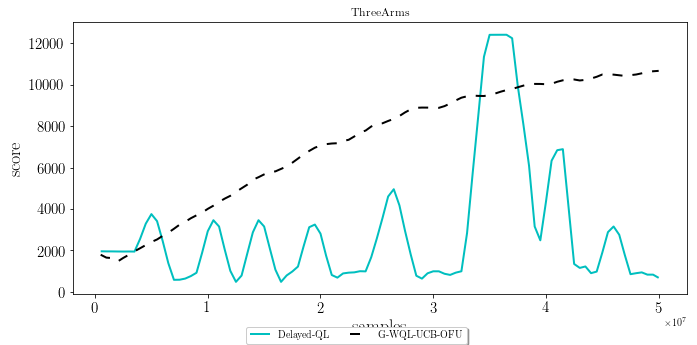

In [24]:
environments = ['ThreeArms']
algorithms = ['delayed-ql','gaussian-ql']
policies = [['greedy'],['ucb'],['weighted-gaussian','ucb'],['boot','weighted'],['eps-greedy', 'boltzmann'],[''],['rmax']]
updates = [[''],['optimistic'],['weighted','mean'],[''], [''],['']]
alg_to_label={
        'particle-ql':'P-WQL',
        'ql':'QL',
        'boot-ql':'BQL',
        'gaussian-ql':'G-WQL',
        'r-max':'Rmax',
        'delayed-ql':'Delayed-QL'
}
policy_to_label={
        'weighted':'W',
        'vpi':'V',
        'eps-greedy':'e-Gree',
        'boltzmann':'Boltz',
        'boot':'Boot',
        'weighted-gaussian':'W',
        'rmax':'',
        'ucb':'UCB',
        'optimistic':'OFU',
        '':''
}
update_to_label={
        'weighted':'W',
        'mean':'M',
        'optimistic':'OFU',
        '':''
}
alg_to_double_vec ={
        'particle-ql':['True'],
        'ql':['True'],
        'boot-ql':['True'],
        'gaussian-ql':['False'],
        'r-max':['False'],
        'delayed-ql':['False']
}
env_to_algs= {
    'Taxi':(['gaussian-ql', 'particle-ql', 'boot-ql', 'ql','delayed-ql'], 
            [['weighted-gaussian','ucb'],['weighted','ucb'],['boot'], ['boltzmann'],['']],
            [['mean'],['mean'],[''],[''],['']]),
    'RiverSwim':(['gaussian-ql', 'particle-ql', 'boot-ql', 'ql','delayed-ql'], 
            [['weighted-gaussian','ucb'],['weighted','ucb'],['boot'], ['boltzmann'],['']],
            [['weighted'],['weighted'],[''],[''],['']]),
    'SixArms':(['gaussian-ql', 'particle-ql', 'boot-ql', 'ql','delayed-ql'], 
            [['weighted-gaussian','ucb'],['weighted','ucb'],['boot'], ['boltzmann'],['']],
            [['weighted'],['weighted'],[''],[''],['']]),
    'KnightQuest':(['gaussian-ql', 'particle-ql', 'boot-ql', 'ql','delayed-ql'], 
            [['weighted-gaussian','ucb'],['weighted','ucb'],['boot'], ['boltzmann'],['']],
            [['weighted'],['weighted'],[''],[''],['']]),
    
}
conf = 0.95
limits=[(-1,17.5),(-10000,80000)]
for e,env in enumerate(environments):
    fig, ax = plt.subplots(1, 1, figsize=(11, 5))
    #fig.suptitle(env)
    #algs, alg_policies, alg_updates = env_to_algs[env]
    i = 0    
    for j, alg in enumerate(algorithms):
        double_vec = alg_to_double_vec[alg]
        
        for pi in policies[j]:
            for u in updates[j]:
                for double in double_vec:
                    '''if pi in ['ucb']:
                        
                        paths = glob.glob("./test_lr/" + env + "/" + alg + "/results_" + pi + "_*_"+ u + "_*_"+"double=False_*.npy")
                    elif alg in ['delayed-ql']:
                        #results_delayed_m=1900_1547483900.8137288.npy
                        paths = glob.glob("./test_lr/" + env + "/" + alg + "/results_delayed_*.npy")
                    elif alg not in ['gaussian-ql']:
                        paths = glob.glob("./test_lr/" + env + "/" + alg + "/results_" + pi + "_*_"+ u + "_*_"+"double=False*.npy")
                    else:
                        paths = glob.glob("./test_lr/" + env + "/" + alg + "/results_" + pi + "_*_"+ u + "_*_"+"double=False*_log_lr=False"+ "*.npy")'''                  
                    paths = glob.glob("./regret_test/"+env+"/"+alg +"/results_*.npy")
                    #print(paths)
                    for p in paths:
                        results = np.load(p)
                        #print(results.shape)
                        n_runs = results.shape[0]
                        try:
                            timesteps = np.cumsum(results[:, 0, :, 0][0])
                            cum_reward_train = results[:, 0, :, 3]
                            cum_reward_test = results[:, 1, :, 3]
                        except:
                            b = np.zeros(shape=results.shape+(11,))
                            for  (x,h,k),value in np.ndenumerate(results):
                                for l in range(11):
                                    b[x,h,k,l]=results[x,h,k][l]
                            results=b
                            timesteps = np.cumsum(results[:, 0, :, 0][0])
                            cum_reward_train = results[:, 0, :, 3]
                            cum_reward_test = results[:, 1, :, 3]
                        

                        #print(cum_reward_test)
                        if alg in ['gaussian-ql','particle-ql']:
                            lab = alg_to_label[alg] + "-" +policy_to_label[pi]+ "-" + update_to_label[u]
                            
                        elif alg in ['boot-ql','ql','delayed-ql']:
                            lab = alg_to_label[alg]
                        else:
                            raise ValueError() #alg_to_label[alg] + "-" + policy_to_label[pi] + "-" + update_to_label[u]
                        ax.set_title(env)
                        ax= plot_ci(timesteps,cum_reward_train, conf, 
                                    n_runs, xlabel='samples', ylabel='score', label=lab, 
                                    ax=ax, linewidth=2.0, linestyle=ls[i], color=col[i])
                        #ax[0].set_ylim(limits[e])
                        '''ax[1].set_title('Offline')
                        ax[1] = plot_ci(timesteps, cum_reward_test, conf, 
                                    n_runs, xlabel='samples', ylabel='score', 
                                    ax=ax[1], linewidth=2.0, linestyle=ls[i], color=col[i])
                        #ax[1].set_ylim(limits[e])'''
                        i += 1
    lgd=fig.legend(loc='lower center', 
                          ncol=2, fancybox=True, shadow=True,bbox_to_anchor=(0.45, -0.01))
    
    #fig.savefig('paper_graphs/'+env+'-'+alg + "-" + pi + "-" + u+".pdf",format='pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')
                       
                    





Delayed : Num timesteps:6523.0
Gaussian old lr: Num timesteps:17000.0
Gaussian new lr: Num timesteps:17000.0
Gaussian old lr new beta: Num timesteps:299.0


/home/amarildo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:96: RuntimeWarning: divide by zero encountered in true_divide
/home/amarildo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:97: RuntimeWarning: divide by zero encountered in true_divide
/home/amarildo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide
/home/amarildo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in true_divide
/home/amarildo/.local/lib/python3.6/site-packages/numpy/core/_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/amarildo/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1976: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0) & (loc == loc)


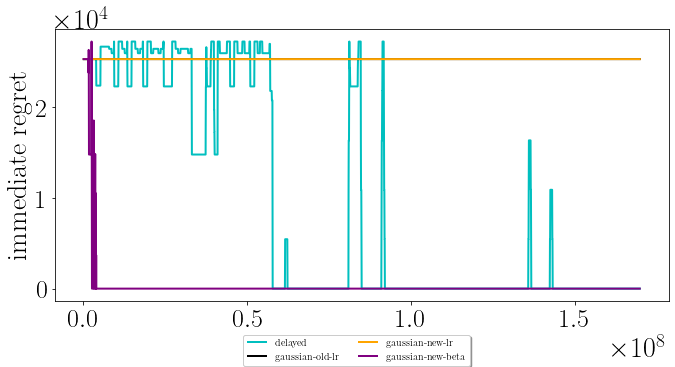

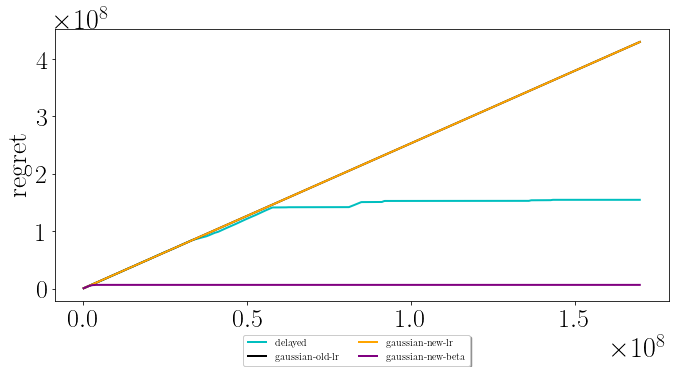

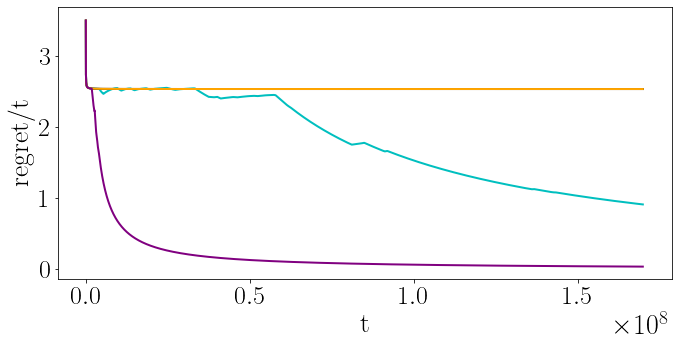

<Figure size 792x360 with 0 Axes>

In [9]:
v_opt =np.array([27247.70632386, 26975.22926062, 26975.22926062, 29999.99990184])
frequency = 10000
d_V = np.load('./regret_results/ThreeArms/delayed/vs_delayed-ql.npy')
delayed_value = d_V[:,0:-1]
delayed_states = d_V[:,-1].astype(int)
#print(delayed_states)
epsilon = 78
g_V_old = np.load('./regret_results/ThreeArms/gaussian_old_lr/vs_gaussian-ql.npy')
gaussian_old_value = g_V_old[:,0:-1]
gaussian_old_states = g_V_old[:,-1].astype(int)

g_V_new = np.load('./regret_results/ThreeArms/gaussian_new_lr/vs_gaussian-ql.npy')
gaussian_new_value = g_V_new[:,0:-1]
gaussian_new_states = g_V_new[:,-1].astype(int)

g_V_beta = np.load('./regret_results/ThreeArms/gaussian_old_lr_new_beta/vs_gaussian-ql.npy')
gaussian_beta_value = g_V_beta[:,0:-1]
gaussian_beta_states = g_V_beta[:,-1].astype(int)

conf = 0.95
n_runs = 1
n_points = min([delayed_value.shape[0],gaussian_beta_value.shape[0],gaussian_new_value.shape[0],gaussian_old_value.shape[0]])

v_d = np.zeros(n_points)
v_g_old = np.zeros(n_points)
v_g_new = np.zeros(n_points)
v_g_beta = np.zeros(n_points)


#Num Timesteps close to optimal 
for i in range(n_points):
    v_d[i] = delayed_value[i,delayed_states[i]]  < v_opt[delayed_states[i]] - epsilon
    v_g_old[i] = gaussian_old_value[i,gaussian_old_states[i]] < v_opt[gaussian_old_states[i]] - epsilon
    v_g_new[i] = gaussian_new_value[i,gaussian_new_states[i]] < v_opt[gaussian_new_states[i]] - epsilon
    v_g_beta[i] = gaussian_beta_value[i,gaussian_beta_states[i]] < v_opt[gaussian_beta_states[i]] - epsilon
    
print("Delayed : Num timesteps:{}".format(np.sum(v_d)))
print("Gaussian old lr: Num timesteps:{}".format(np.sum(v_g_old)))
print("Gaussian new lr: Num timesteps:{}".format(np.sum(v_g_new)))
print("Gaussian old lr new beta: Num timesteps:{}".format(np.sum(v_g_beta)))

timesteps =np.array([i*frequency for i in range(n_points)])

#Immediate regret
for i in range(n_points):
    v_d[i] = v_opt[delayed_states[i]] - delayed_value[i,delayed_states[i]] 
    v_g_old[i] = v_opt[gaussian_old_states[i]] - gaussian_old_value[i,gaussian_old_states[i]]
    v_g_new[i] = v_opt[gaussian_new_states[i]] - gaussian_new_value[i,gaussian_new_states[i]]
    v_g_beta[i] = v_opt[gaussian_beta_states[i]] - gaussian_beta_value[i,gaussian_beta_states[i]]
    
fig, ax = plt.subplots(1, 1, figsize=(11, 5))
ax= plot_ci(timesteps,np.expand_dims(v_d,0), conf, 
                                    n_runs, xlabel='t', ylabel='immediate regret', label='delayed', 
                                    ax=ax, linewidth=2.0, linestyle=ls[0], color=col[0])
ax= plot_ci(timesteps,np.expand_dims(v_g_old,0), conf, 
                                    n_runs, xlabel='t', ylabel='immediate regret', label='gaussian-old-lr', 
                                    ax=ax, linewidth=2.0, linestyle=ls[0], color=col[1])
ax= plot_ci(timesteps,np.expand_dims(v_g_new,0), conf, 
                                    n_runs, xlabel='t', ylabel='immediate regret', label='gaussian-new-lr', 
                                    ax=ax, linewidth=2.0, linestyle=ls[0], color=col[2])
ax= plot_ci(timesteps,np.expand_dims(v_g_beta,0), conf, 
                                    n_runs, xlabel='t', ylabel='immediate regret', label='gaussian-new-beta', 
                                    ax=ax, linewidth=2.0, linestyle=ls[0], color=col[3])
lgd=fig.legend(loc='lower center', 
                          ncol=2, fancybox=True, shadow=True,bbox_to_anchor=(0.45, -0.01))
#Cumulative regret 
v_d = np.cumsum(v_d)
v_g_old = np.cumsum(v_g_old)
v_g_new = np.cumsum(v_g_new)
v_g_beta = np.cumsum(v_g_beta)

fig, ax = plt.subplots(1, 1, figsize=(11, 5))
ax= plot_ci(timesteps,np.expand_dims(v_d,0), conf, 
                                    n_runs, xlabel='t', ylabel='regret', label='delayed', 
                                    ax=ax, linewidth=2.0, linestyle=ls[0], color=col[0])
ax= plot_ci(timesteps,np.expand_dims(v_g_old,0), conf, 
                                    n_runs, xlabel='t', ylabel='regret', label='gaussian-old-lr', 
                                    ax=ax, linewidth=2.0, linestyle=ls[0], color=col[1])
ax= plot_ci(timesteps,np.expand_dims(v_g_new,0), conf, 
                                    n_runs, xlabel='t', ylabel='regret', label='gaussian-new-lr', 
                                    ax=ax, linewidth=2.0, linestyle=ls[0], color=col[2])
ax= plot_ci(timesteps,np.expand_dims(v_g_beta,0), conf, 
                                    n_runs, xlabel='t', ylabel='regret', label='gaussian-new-beta', 
                                    ax=ax, linewidth=2.0, linestyle=ls[0], color=col[3])
 
lgd=fig.legend(loc='lower center', 
                          ncol=2, fancybox=True, shadow=True,bbox_to_anchor=(0.45, -0.01))



#Cumulative value function of policy 
'''for i in range(delayed_value.shape[0]):
    v_d[i] = delayed_value[i,delayed_states[i]] 
    v_g[i] = gaussian_value[i,gaussian_states[i]]'''
               
v_d = v_d / timesteps
v_g_old = v_g_old / timesteps
v_g_new = v_g_new / timesteps
v_g_beta = v_g_beta / timesteps  
               
#Cumulative
fig, ax = plt.subplots(1, 1, figsize=(11, 5))
ax= plot_ci(timesteps,np.expand_dims(v_d,0), conf, 
                                    n_runs, xlabel='t', ylabel='regret/t', label='delayed', 
                                    ax=ax, linewidth=2.0, linestyle=ls[0], color=col[0])
ax= plot_ci(timesteps,np.expand_dims(v_g_old,0), conf, 
                                    n_runs, xlabel='t', ylabel='regret/t', label='gaussian-old-lr', 
                                    ax=ax, linewidth=2.0, linestyle=ls[0], color=col[1] )
ax= plot_ci(timesteps,np.expand_dims(v_g_new,0), conf, 
                                    n_runs, xlabel='t', ylabel='regret/t', label='gaussian-new-lr', 
                                    ax=ax, linewidth=2.0, linestyle=ls[0], color=col[2] )
ax= plot_ci(timesteps,np.expand_dims(v_g_beta,0), conf, 
                                    n_runs, xlabel='t', ylabel='regret/t', label='gaussian-new-beta', 
                                    ax=ax, linewidth=2.0, linestyle=ls[0], color=col[3] )
               
#lgd=fig.legend(loc='lower center', 
 #                         ncol=2, fancybox=True, shadow=True,bbox_to_anchor=(0.45, -0.01))
legend_labels = ['Delayed-QL','G-WQL-old-lr','G-WQL-new-lr','G-WQL-new-beta']
legend_colors = col[0:len(legend_labels)]
legend_markers = markers[0:len(legend_labels)]
#fig.savefig('images/regret-ThreeArms.pdf',format='pdf', bbox_inches='tight')
fig = plt.figure(figsize=(11, 5))
patches = [mlines.Line2D([], [], color=legend_colors[i],
                          label=legend_labels[i])  for i in range(len(legend_labels))]

lgd=fig.legend( patches, legend_labels, ncol=len(legend_labels), 
           loc='center')
#fig.savefig('images/regret-legend.pdf',format='pdf',bbox_extra_artists=(lgd,), bbox_inches='tight') 



Delayed : Num timesteps:6523.0
Gaussian pac: Num timesteps:15400.0


/home/amarildo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in true_divide
/home/amarildo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide


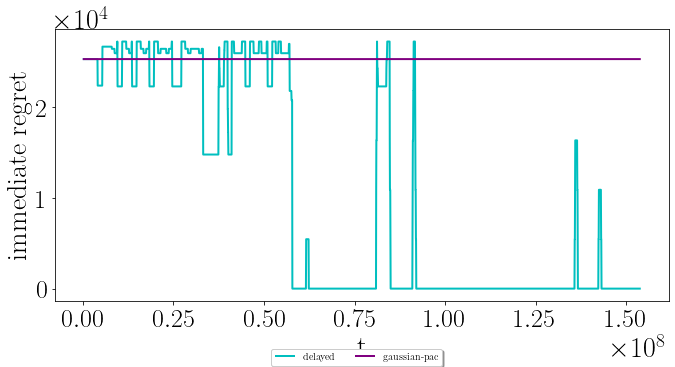

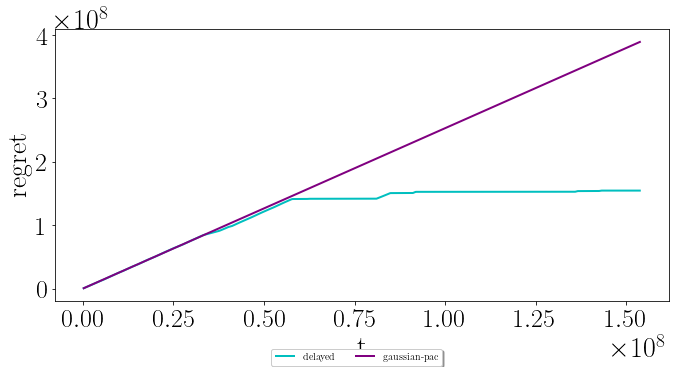

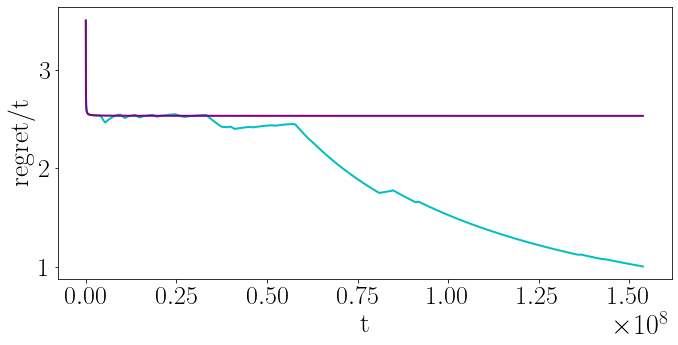

<Figure size 792x360 with 0 Axes>

In [13]:
v_opt =np.array([27247.70632386, 26975.22926062, 26975.22926062, 29999.99990184])
frequency = 10000
d_V = np.load('./regret_results/ThreeArms/delayed/vs_delayed-ql.npy').mean(axis=0)
delayed_value = d_V[:,0:-1]
delayed_states = d_V[:,-1].astype(int)
#print(delayed_states)
epsilon = 78

g_V_pac = np.load('./regret_results/ThreeArms/gaussian_pac/vs_gaussian-ql.npy').mean(axis=0)
gaussian_pac_value = g_V_pac[:,0:-1]
gaussian_pac_states = g_V_pac[:,-1].astype(int)

conf = 0.95
n_runs = 1
n_points = min([delayed_value.shape[0],gaussian_pac_value.shape[0]])

v_d = np.zeros(n_points)
v_g_pac = np.zeros(n_points)


#Num Timesteps close to optimal 
for i in range(n_points):
    v_d[i] = delayed_value[i,delayed_states[i]]  < v_opt[delayed_states[i]] - epsilon
    v_g_pac[i] = gaussian_pac_value[i,gaussian_pac_states[i]] < v_opt[gaussian_pac_states[i]] - epsilon
    
print("Delayed : Num timesteps:{}".format(np.sum(v_d)))
print("Gaussian pac: Num timesteps:{}".format(np.sum(v_g_pac)))

timesteps =np.array([i*frequency for i in range(n_points)])

#Immediate regret
for i in range(n_points):
    v_d[i] = v_opt[delayed_states[i]] - delayed_value[i,delayed_states[i]] 
    v_g_pac[i] = v_opt[gaussian_pac_states[i]] - gaussian_pac_value[i,gaussian_pac_states[i]]
    
fig, ax = plt.subplots(1, 1, figsize=(11, 5))
ax= plot_ci(timesteps,np.expand_dims(v_d,0), conf, 
                                    n_runs, xlabel='t', ylabel='immediate regret', label='delayed', 
                                    ax=ax, linewidth=2.0, linestyle=ls[0], color=col[0])

ax= plot_ci(timesteps,np.expand_dims(v_g_pac,0), conf, 
                                    n_runs, xlabel='t', ylabel='immediate regret', label='gaussian-pac', 
                                    ax=ax, linewidth=2.0, linestyle=ls[0], color=col[3])
lgd=fig.legend(loc='lower center', 
                          ncol=2, fancybox=True, shadow=True,bbox_to_anchor=(0.45, -0.01))
#Cumulative regret 
v_d = np.cumsum(v_d)
v_g_pac = np.cumsum(v_g_pac)

fig, ax = plt.subplots(1, 1, figsize=(11, 5))
ax= plot_ci(timesteps,np.expand_dims(v_d,0), conf, 
                                    n_runs, xlabel='t', ylabel='regret', label='delayed', 
                                    ax=ax, linewidth=2.0, linestyle=ls[0], color=col[0])
ax= plot_ci(timesteps,np.expand_dims(v_g_pac,0), conf, 
                                    n_runs, xlabel='t', ylabel='regret', label='gaussian-pac', 
                                    ax=ax, linewidth=2.0, linestyle=ls[0], color=col[3])
 
lgd=fig.legend(loc='lower center', 
                          ncol=2, fancybox=True, shadow=True,bbox_to_anchor=(0.45, -0.01))



#Cumulative value function of policy 
'''for i in range(delayed_value.shape[0]):
    v_d[i] = delayed_value[i,delayed_states[i]] 
    v_g[i] = gaussian_value[i,gaussian_states[i]]'''
               
v_d = v_d / timesteps
v_g_pac = v_g_pac / timesteps  
               
#Cumulative
fig, ax = plt.subplots(1, 1, figsize=(11, 5))
ax= plot_ci(timesteps,np.expand_dims(v_d,0), conf, 
                                    n_runs, xlabel='t', ylabel='regret/t', label='delayed', 
                                    ax=ax, linewidth=2.0, linestyle=ls[0], color=col[0])
ax= plot_ci(timesteps,np.expand_dims(v_g_pac,0), conf, 
                                    n_runs, xlabel='t', ylabel='regret/t', label='gaussian-pac', 
                                    ax=ax, linewidth=2.0, linestyle=ls[0], color=col[3] )
               
#lgd=fig.legend(loc='lower center', 
 #                         ncol=2, fancybox=True, shadow=True,bbox_to_anchor=(0.45, -0.01))
legend_labels = ['Delayed-QL','G-WQL-pac']
legend_colors = col[0:len(legend_labels)]
legend_markers = markers[0:len(legend_labels)]
#fig.savefig('images/regret-ThreeArms.pdf',format='pdf', bbox_inches='tight')
fig = plt.figure(figsize=(11, 5))
patches = [mlines.Line2D([], [], color=legend_colors[i],
                          label=legend_labels[i])  for i in range(len(legend_labels))]

lgd=fig.legend( patches, legend_labels, ncol=len(legend_labels), 
           loc='center')
#fig.savefig('images/regret-legend.pdf',format='pdf',bbox_extra_artists=(lgd,), bbox_inches='tight') 

